## Multiple Linear Regression

In this assignment, I have tried model a multile regression between the mileage of a car given various predictor variables like number of cylinders, engine displacement, engine horse power, weight of the car etc. I have taken the [Auto MPG Data Set](http://archive.ics.uci.edu/ml/datasets/Auto+MPG) from UCI Machine Learning Repository. 

In [1]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src=pinto.jpg></td><td><img src=matador.jpg></td></tr></table>"))

,


## Loading the Libraries

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

## Loading the Data Set

In [3]:
data = pd.read_csv("auto-mpg.data", 
                   delim_whitespace=True, 
                   header=None,
                   dtype={'cylinders':'category', 'model year':'category', 'origin':'category', 'car name':'category'},
                   names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year',
                          'origin', 'car name'])

## Data Summary and Data Management

In [4]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


From the above table we can conclude that we have following **numerical** variables<br>
<ol>
    <li>mpg</li>
    <li>displacement</li>
    <li>horspower</li>
    <li>weight</li>
    <li>acceleration</li>
</ol><br>
And categorical variables are as follows-<br>
<ol>
    <li>cylinders</li>
    <li>model year</li>
    <li>origin</li>
    <li>car name</li>
</ol><br>
The function **data.describe()** provides the summary of all the numerical variables in our dataset

In [5]:
data.describe()

,mpg,displacement,weight,acceleration
count,398.000000,398.000000,398.000000,398.000000
mean,23.514573,193.425879,2970.424623,15.568090
std,7.815984,104.269838,846.841774,2.757689
min,9.000000,68.000000,1613.000000,8.000000
25%,17.500000,104.250000,2223.750000,13.825000
50%,23.000000,148.500000,2803.500000,15.500000
75%,29.000000,262.000000,3608.000000,17.175000
max,46.600000,455.000000,5140.000000,24.800000


But as we can see the summary of the numerical variable **horsepower** is missing. It may be due to the reason that python did not interpreted it as a numerical variable. Let's find out the reason

In [6]:
data['horsepower'].describe()

count       398
unique       94
top       150.0
freq         22
Name: horsepower, dtype: object

We got the solution, the variable **horsepower** is treated as an **object** rather than a numeric variable. So we need to convert this variable to numeric before we can produce its summary

In [7]:
data['horsepower'] = pd.to_numeric(data['horsepower'])

ValueError: Unable to parse string "?" at position 32

What happened? We got a value error saying **Unable to parse string "?" at position 32**. Lets check what's there at the position 32

In [8]:
data['horsepower'][32]

'?'

This means the 32nd observation has **missing value** for the variable horsepower and the missing value is coded as **?** in this dataset. So we need to treat this missing value before we can proceed further. There are many ways to handle missing value. In this case, first I will check how many more observations have coded missing values as **?** and then I will simply replace **?** with the variables value at its previous observation.

In [9]:
missing_indexes = data[data['horsepower'] == "?"]
missing_indexes.index

Int64Index([32, 126, 330, 336, 354, 374], dtype='int64')

In [10]:
import warnings
warnings.filterwarnings("ignore")

data['horsepower'][32] = data['horsepower'][31]
data['horsepower'][126] = data['horsepower'][125]
data['horsepower'][330] = data['horsepower'][329]
data['horsepower'][336] = data['horsepower'][335]
data['horsepower'][354] = data['horsepower'][353]
data['horsepower'][374] = data['horsepower'][373]

data['horsepower'] = pd.to_numeric(data['horsepower'])

Now that we have replaced our missing values, we will now be able to see the summary of the variable **horsepower**

In [11]:
data.describe()

,mpg,displacement,horsepower,weight,acceleration
count,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,193.425879,104.178392,2970.424623,15.568090
std,7.815984,104.269838,38.294837,846.841774,2.757689
min,9.000000,68.000000,46.000000,1613.000000,8.000000
25%,17.500000,104.250000,75.000000,2223.750000,13.825000
50%,23.000000,148.500000,92.500000,2803.500000,15.500000
75%,29.000000,262.000000,125.000000,3608.000000,17.175000
max,46.600000,455.000000,230.000000,5140.000000,24.800000


For categorical variables, the summary can be listed by using the function **value_counts()** for each categorical variables respectively.

In [12]:
data['cylinders'].value_counts()

4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64

In [13]:
data['model year'].value_counts()

73    40
78    36
76    34
82    31
75    30
81    29
80    29
79    29
70    29
77    28
72    28
71    28
74    27
Name: model year, dtype: int64

In [14]:
data['origin'].value_counts()

1    249
3     79
2     70
Name: origin, dtype: int64

## Hypothesis Generation and Recoding of Variables

I want to build a multiple regression the following explanatory variables<br>
<ol>
    <li>cylinders (categorical variable)</li>
    <li>displacement (continuous variable)</li>
    <li>horspower (continuous variable)</li>
    <li>weight (continuous variable)</li>
    <li>acceleration (continuous variable)</li>
</ol><br>
And the response variable as
<ol><li>mpg (continuous variable)</li></ol>

**cylinder** variable has 5 different levels viz. 3, 4, 5, 6 and 8. So we need to recode the levels as follows

In [15]:
data['cylinders'] = pd.to_numeric(data['cylinders'])

recode = {3: 0, 4: 1, 5:2, 6:3, 8:4}
data['cylinders']=data['cylinders'].map(recode)

data['cylinders'] = data['cylinders'].astype('category')
data['cylinders'].value_counts()

1    204
4    103
3     84
0      4
2      3
Name: cylinders, dtype: int64

We have successfully recoded the categorical variable **cylinders**. Now we need to perform **centering** for those numerical varaibles whose range does not contain 0 (zero). From the summary table we can see that none of the numerical predictor variable has 0 (zero) in their range. So we have to do **centering** for all the numerical predictor variables.

In [16]:
data['displacement'] = round(data['displacement'] - data['displacement'].mean(), 2)
data['horsepower'] = round(data['horsepower'] - data['horsepower'].mean(), 2)
data['weight'] = round(data['weight'] - data['weight'].mean(), 2)
data['acceleration'] = round(data['acceleration'] - data['acceleration'].mean(), 2)

In [17]:
data[['displacement', 'horsepower', 'weight', 'acceleration']].describe()

,displacement,horsepower,weight,acceleration
count,398.000000,398.000000,398.000000,398.000000
mean,-0.004121,-0.001608,0.004623,-0.001910
std,104.269838,38.294837,846.841774,2.757689
min,-125.430000,-58.180000,-1357.420000,-7.570000
25%,-89.180000,-29.180000,-746.670000,-1.745000
50%,-44.930000,-11.680000,-166.920000,-0.070000
75%,68.570000,20.820000,637.580000,1.605000
max,261.570000,125.820000,2169.580000,9.230000


## Regression Modelling

After completing the data management strp, now we are ready for our regression modeling

In [18]:
reg1 = smf.ols('mpg ~ cylinders + displacement + horsepower + weight + acceleration', data=data).fit()
print (reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     139.6
Date:                Wed, 27 Sep 2017   Prob (F-statistic):          2.36e-109
Time:                        00:45:49   Log-Likelihood:                -1113.2
No. Observations:                 398   AIC:                             2244.
Df Residuals:                     389   BIC:                             2280.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         17.3487      2.211      7.

From the above results, we can see that the variables **cylinders[T.3], displacement and acceleration** have p-values > 0.05 and we can conclude that they are not significant in predicting mpg of car. The result does not support my hypothesis of association between these three variables. Hence we can remove these three variables from our regression modeling. 

In [19]:
reg2 = smf.ols('mpg ~ horsepower + weight', data=data).fit()
print (reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     473.2
Date:                Wed, 27 Sep 2017   Prob (F-statistic):          1.36e-105
Time:                        00:45:51   Log-Likelihood:                -1139.3
No. Observations:                 398   AIC:                             2285.
Df Residuals:                     395   BIC:                             2297.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.5145      0.213    110.328      0.0

Now, our model looks good. All the predictor variables **horsepower** and **weight** of the car are siginifact with p-values less than 0.05 and 70.6% variability in the response variable is explained by the these two predictor variables. There is also no evidence of confounding for the association between primary explanatory variable and response variable.<br><br>
The regression equation is given by, **mpg = Intercept - 0.0475 * horsepower - 0.0058 * weight**<br><br>But we also need to perform the residual analysis to see whether our model meets the specifications or not.

## Residual Analysis: Evaluating Model Fit

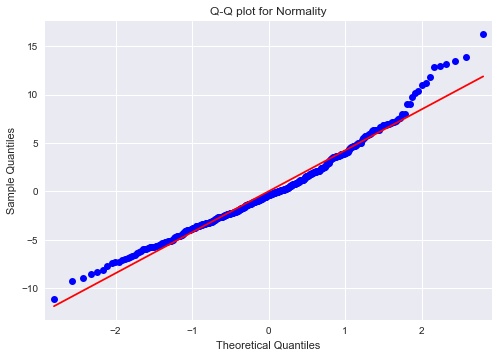

In [20]:
#Q-Q plot for normality
fig1=sm.qqplot(reg2.resid, line='r')
plt.title("Q-Q plot for Normality")
plt.show()

The above Q-Q plot shows that the model residual does not obey the normality beyond (+-) 2 standard deviations from the mean residual. So there is a scope for improvement in the model.

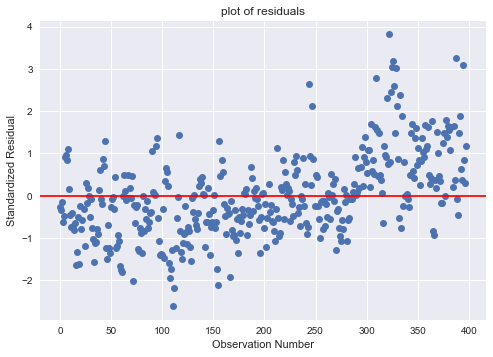

In [21]:
# simple plot of residuals
stdres=pd.DataFrame(reg2.resid_pearson)
plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.title('plot of residuals')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')
plt.show()

Above residual plot shows few of the observations move beyond the 95% confidence interval level (i.e. +- 2 standard deviations). So these observations might be potential outliers and may affect our regression model.

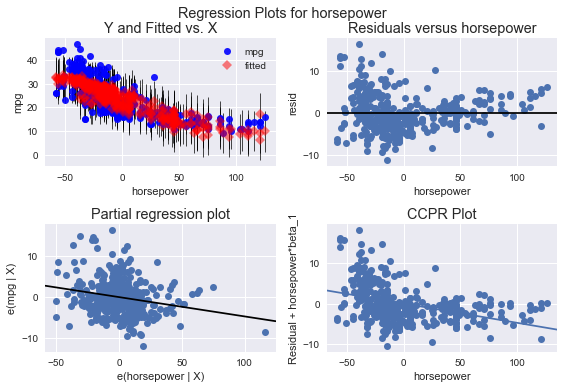

In [22]:
# additional regression diagnostic plots
fig2 = plt.figure()
fig2 = sm.graphics.plot_regress_exog(reg2,  "horsepower", fig=fig2)
fig2

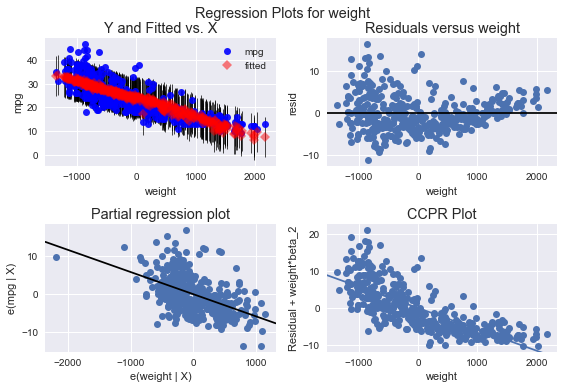

In [23]:
# additional regression diagnostic plots
fig3 = plt.figure()
fig3 = sm.graphics.plot_regress_exog(reg2,  "weight", fig=fig3)
fig3

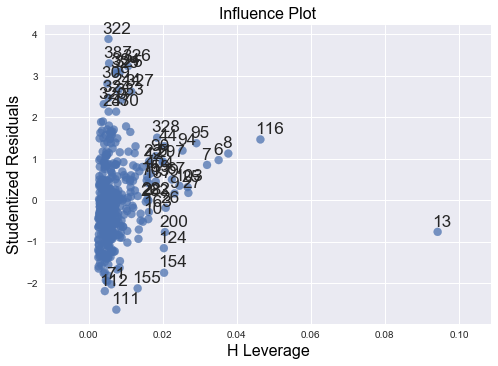

In [24]:
# leverage plot
fig4=sm.graphics.influence_plot(reg2, size=8)
fig4

The leverage plot shows, almost all the observations have leverage values closer to zero, except the observation **#13** whose leverage value is near to 1. This observation might affect our modeling and hence we should remove this observation from our analysis.